<a href="https://colab.research.google.com/github/ls2092/CV/blob/main/DMML_GROUP_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ THIS**
*IMPORTANT*

*   After training / doing any changes to the data, make sure to save those changes in the google drive file. *(THIS IS VERY IMPORTANT AS AFTER YOU TUN OFF THE VM, ALL OUR DATA OF THE TRAINED MODEL WILL NOT SAVE, SO UNLESS YOU SAVE IT THERE IS NO POINT)*

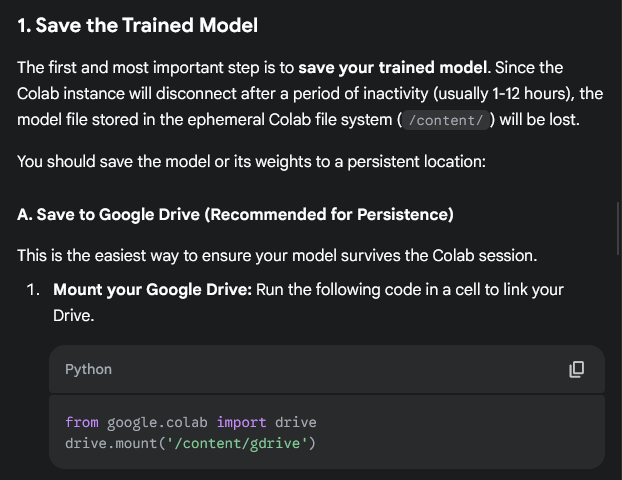

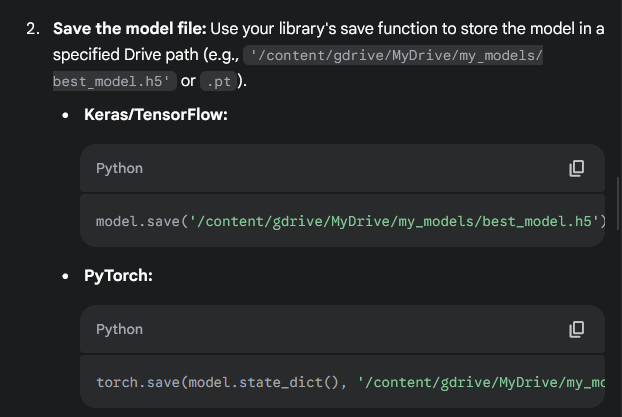

*   After finishing your work , make sure you do **CTRL + S** to save the document and then also commit the changes on the github by going to **File-> Save a copy in GITHUB**, log into your github and select our repo and then make sure the name of the **ipynb** file already matches what is already there in the repo **(DMML_GROUP_12.ipynb)** and put a commit message and save it there.

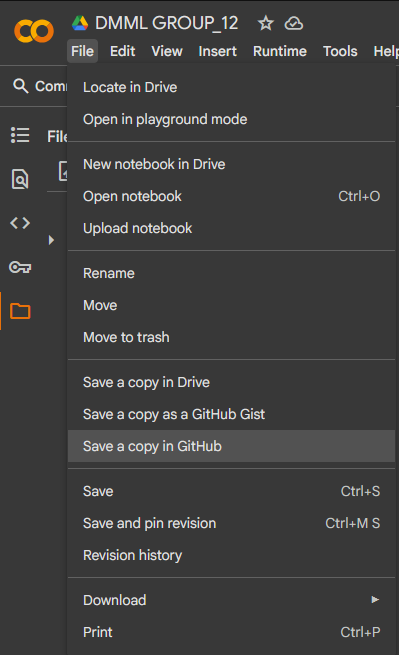



* A**BOVE EACH LAB, ADD YOUR DEPENDANCIES AND INSTALL THEM IF REQUIRED AS EACH TIME THE VM STOPS, THOSE DEPENDANCIES COULD GET DELETED AS WELL. (EG - pip install numpy, mathplotlib, etc) (IF REQUIRED)**

# **RUN THIS TO CONNECT TO THE DRIVE**


*   THIS HAS TO BE RUN TO CONNECT TO THE DRIVE EVERYTIME YOU START THE VM




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Pre processing features in Ad_table - VIR**

Modified the Ad_table to remove the Ad_month and saved it as a new table called Adv_table. Decided to not use Basic_table, Sales_table, Trim_table for the training, as it is not required for our aim.

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/DMML DATA/tables_V2.0/Ad_table.csv'

df = pd.read_csv(file_path, low_memory=False)
df.head()

df = df.drop(['Adv_month'], axis=1)

df.to_csv('/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv', index=False)


# Lab 2 Dependancies

# Lab 2


Data loaded successfully.
Merged Data Shape: (222841, 16)
Unique Car Makes after merge: 60

Training set size: 178296
Testing set size: 44545


/tmp/ipython-input-1652576494.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
/tmp/ipython-input-1652576494.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])
/tmp/ipython-input-1652576494.py:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in 


Starting XGBoost training...
Training complete.

--- Model Performance Metrics ---
R-squared (R²): -1.4515
Root Mean Squared Error (RMSE): 29,421.19

An R² of 1.0 indicates a perfect fit, while an RMSE measures the average magnitude of the error.
The average MSRP in the test set is: 21,139.22
The model's typical error (RMSE) is 139.18% of the average MSRP.

--- Actual vs. Predicted Prices (Sample of Test Data) ---
       Actual_MSRP  Predicted_MSRP
48299      14425.0    56375.679688
48215      14425.0    69374.203125
48295      15255.0    57732.789062
48164      14425.0    56342.851562
48212      14425.0    68541.500000
48183      14425.0    56664.460938
48075      29515.0    81730.976562
48273      14425.0    56664.460938
48157      15255.0    57732.789062
48286      14425.0    56664.460938


# Lab 3 Dependancies

In [6]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


price_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"
adv_table = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"

price_data = pd.read_csv(price_table, low_memory=False)
adv_data = pd.read_csv(adv_table, low_memory=False)

#stripping whitespace from all column names to prevent KeyError
price_data.columns = price_data.columns.str.strip()
adv_data.columns = adv_data.columns.str.strip()

print("Data Loaded")

#checking if data got loaded
print(f"Price Table size: {price_data.shape}")
print(f"Ad Table size: {adv_data.shape}")

#data Cleaning and Preprocessing

# Target Variable is resale price which is 'Price' from Adv_Table
TARGET_COLUMN = 'Price'

#Clean Engin_size in Adv_table to remove non-numeric labels like L(litre)
def clean_engine_size(size_str):
   # """Converts engine size string (e.g., '2.0L') to float (2.0)."""
    if pd.isna(size_str):
        return None
    try:
        # Remove 'L'
        return float(str(size_str).replace('L', '').strip())
    except ValueError:
        return None


adv_data['Engine_size_L'] = adv_data['Engin_size'].apply(clean_engine_size)
#drop original Engin_size column
adv_data = adv_data.drop(columns=['Engin_size'])

#Clean and convert Runned_Miles and Price to numeric (removing commas)
def clean_and_convert_numeric(series):
    #"""Removes commas and attempts to convert a series to numeric, replacing errors with NaN."""
    # Convert to string, replace common non-numeric characters (like commas), then coerce to numeric
    clean_series = series.astype(str).str.replace(r'[$,]', '', regex=True).str.strip()
    return pd.to_numeric(clean_series, errors='coerce')

adv_data['Runned_Miles'] = clean_and_convert_numeric(adv_data['Runned_Miles'])
# Apply cleaning to 'Price', which is now the TARGET
adv_data['Price'] = clean_and_convert_numeric(adv_data['Price'])


#Merge Data
#merge is done on Maker, Genmodel_ID, and Year to link advertisement features to the specific year's MSRP/Entry_price
merge_cols_adv = ['Maker', 'Genmodel_ID', 'Reg_year']
merge_cols_price = ['Maker', 'Genmodel_ID', 'Year']

#rename 'Reg_year' in adv_data to 'Year' for consistent merging
adv_data = adv_data.rename(columns={'Reg_year': 'Year'})

#merging the Price_table just to get the 'Entry_price' as a feature.
merged_df = pd.merge(
    adv_data,
    # Pulling 'Entry_price' to use as a feature
    price_data[['Maker', 'Genmodel_ID', 'Year', 'Entry_price']],
    on=['Maker', 'Genmodel_ID', 'Year'],
    how='left'
)

print(f"\n--- Merged Data Shape: {merged_df.shape} ---")
print(f"Number of unique Makers: {merged_df['Maker'].nunique()}")

#Handle Missing Values and Feature selection
# Dropping rows with nulls
merged_df = merged_df.dropna(subset=[
    'Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', TARGET_COLUMN
])

#Features to be used for prediction
num_features = ['Runned_Miles', 'Engine_size_L', 'Seat_num', 'Door_num', 'Adv_year', 'Entry_price']
#filling null values in 'Entry_price' with the median
merged_df['Entry_price'] = merged_df['Entry_price'].fillna(merged_df['Entry_price'].median())

categorical_features = ['Maker', 'Genmodel', 'Color', 'Bodytype', 'Gearbox', 'Fuel_type']
total_features = num_features + categorical_features

X = merged_df[total_features]
y = merged_df[TARGET_COLUMN]

# Convert categorical features into numerical format using One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

#Test Train Split (80-20 per Maker): if there are 80 cars of Maker 'Bentley' then 0.80*80 will be used for training and 0.20*80 will be used for testing purposes.
def custom_group_split(df, group_col, test_size=0.2):

    training_data = []
    testing_data = []

    # Calculate the minimum number of samples needed for a split
    # If test_size is 0.2, min samples needed is 2 (1 in train, 1 in test)
    min_samples_required = 1 / (1 - test_size)
    if min_samples_required <= 1:
        min_samples_required = 2

    skipped_groups = 0

    for group_name, group in df.groupby(group_col):

        if len(group) < 2:
            # Skip this group if it's too small to be split into non-empty train/test sets
            skipped_groups += 1
            training_data.extend(group.index)
            continue

        # Use simple train_test_split on the indices of the group
        group_train_indices, group_test_indices = train_test_split(
            group.index,
            test_size=test_size,
            random_state=42
        )
        training_data.extend(group_train_indices)
        testing_data.extend(group_test_indices)

    if skipped_groups > 0:
        print(f"\nWarning: Skipped {skipped_groups} Maker groups (rows) that had fewer than 2 samples to split.")

    return df.loc[training_data].index, df.loc[testing_data].index

# Get the indices for the custom split
train_index, test_index = custom_group_split(merged_df, 'Maker', test_size=0.2)

# Create the final train and test sets using the indices
X_train = X_encoded.loc[train_index]
X_test = X_encoded.loc[test_index]
y_train = y.loc[train_index]
y_test = y.loc[test_index]

# Check split distribution for verification)
print(f"\n--- Train/Test Split ---")
print(f"Total samples: {len(X_encoded)}")
print(f"Training samples: {len(X_train)} ({len(X_train)/len(X_encoded):.1%})")
print(f"Testing samples: {len(X_test)} ({len(X_test)/len(X_encoded):.1%})")

# Train XGBoost Model
print("\nTraining XGBoost Regressor for Resale Price")

# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

xgb_model.fit(X_train, y_train)

print("Training complete.")

# --- 5. Predict and Evaluate ---
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\nModel Evaluation (Resale Price)")
print(f"R-squared (Accuracy): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

#Output Actual vs Predicted Prices
results_df = pd.DataFrame({
    'Actual_Resale_Price': y_test,
    'Predicted_Resale_Price': y_pred.round(2)
})

# Add Maker and Genmodel back for context
context_df = merged_df.loc[test_index][['Maker', 'Genmodel', 'Year']]
results_df = context_df.merge(results_df, left_index=True, right_index=True)

print("\n--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---")
print(results_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))

Data Loaded
Price Table size: (6333, 5)
Ad Table size: (268255, 15)

--- Merged Data Shape: (268255, 16) ---
Number of unique Makers: 88


--- Train/Test Split ---
Total samples: 255898
Training samples: 204693 (80.0%)
Testing samples: 51205 (20.0%)

Training XGBoost Regressor for Resale Price
Training complete.

Model Evaluation (Resale Price)
R-squared (Accuracy): 0.9422
Mean Absolute Error (MAE): 2,583.35
Root Mean Squared Error (RMSE): 4,792.05

--- Actual vs. Predicted Resale Prices (Sample of Test Set) ---
| Maker   | Genmodel   | Year   | Actual_Resale_Price   | Predicted_Resale_Price   |
|:--------|:-----------|:-------|:----------------------|:-------------------------|
| Abarth  | 595        | 2018   | 13000                 | 13145.8                  |
| Abarth  | 595C       | 2019   | 26075                 | 20144.3                  |
| Abarth  | 595        | 2014   | 10990                 | 8254.4                   |
| Abarth  | 595        | 2016   | 11500                 |

# Lab 3


# Tabular Data Preprocessing


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor


ad_table_path = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Adv_table.csv"
price_table_path = "/content/drive/MyDrive/DMML DATA/tables_V2.0/Price_table.csv"


df_ad = pd.read_csv(ad_table_path, low_memory=False)
df_price = pd.read_csv(price_table_path, low_memory=False)

df_ad.columns = df_ad.columns.str.strip()
df_price.columns = df_price.columns.str.strip()

#cleaning price to numeric values only
df_ad['Price'] = pd.to_numeric(df_ad['Price'], errors='coerce')

#merging tables on gen model ID and Year
merged_data = pd.merge(
  df_ad,
  df_price,
  left_on=['Genmodel_ID', 'Reg_year'],
  right_on=['Genmodel_ID', 'Year'],
  how='left',
  suffixes=('', '_price')
)

#Drop redundant columns
if 'Year' in merged_data.columns:
  merged_data = merged_data.drop(columns=['Year'])
merged_data = merged_data.drop(columns=['Maker_price', 'Genmodel_price'], errors='ignore')

#checking if merge worked
print("Merged data shape:", merged_data.shape)
print("Columns:", merged_data.columns.tolist())
print(merged_data.head())

#null counts
nan_entry = merged_data['Entry_price'].isnull().sum()
print(f"\nNumber of NaN Entry_price values: {nan_entry}")
print(f"Percentage unmatched: {(nan_entry / len(merged_data)) * 100:.2f}%")
print(f"Number of NaN Price values after cleaning: {merged_data['Price'].isnull().sum()}")

#handling nulls
merged_data = merged_data.dropna(subset=['Price'])
print(f"Rows after dropping NaN Price: {len(merged_data)}")

#test train split (80- 20) based on the counts of each 'Maker'
# Impute Entry_price: Median per Maker, then overall median
merged_data['Entry_price'] = merged_data.groupby('Maker')['Entry_price'].transform(
    lambda x: x.fillna(x.median())
)
overall_median = merged_data['Entry_price'].median()
merged_data['Entry_price'] = merged_data['Entry_price'].fillna(overall_median)


numeric_cols_to_clean = ['Runned_Miles', 'Engin_size']
for col in numeric_cols_to_clean:
    merged_data[col] = pd.to_numeric(merged_data[col].astype(str).str.replace('L', ''), errors='coerce')
    merged_data[col] = merged_data[col].fillna(merged_data[col].median())

print(f"NaN Entry_price after imputation: {merged_data['Entry_price'].isnull().sum()}")
print(f"Final dataset shape: {merged_data.shape}")


merged_data = merged_data.drop(columns=['MSRP_Category'], errors='ignore')



np.random.seed(42)
train_indices = []
test_indices = []

for maker, group in merged_data.groupby('Maker'):
    n_samples = len(group)
    if n_samples == 0:
      continue
    n_train = int(0.8 * n_samples)

    train_idx = group.sample(n=n_train, random_state=42).index
    train_indices.extend(train_idx)

    test_idx = group.drop(train_idx).index
    test_indices.extend(test_idx)

df_train = merged_data.loc[train_indices].reset_index(drop=True)
df_test = merged_data.loc[test_indices].reset_index(drop=True)

#verifying split
print(f"\nTrain set size: {len(df_train)} ({len(df_train)/len(merged_data)*100:.1f}%)")
print(f"Test set size: {len(df_test)} ({len(df_test)/len(merged_data)*100:.1f}%)")


#XGBoost implementation

notIncluded_features = ['Adv_ID', 'Genmodel', 'Genmodel_ID', 'Price']
X_train = df_train.drop(columns=notIncluded_features)
y_train = df_train['Price']

X_test = df_test.drop(columns=notIncluded_features)
y_test = df_test['Price']

#Maker is now correctly included in X_train and will be encoded
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# FIX 3 (Memory): Remove high-cardinality column(s) that are still objects
# We will remove any remaining object columns with more than 100 unique values
high_cardinality_cols = [col for col in categorical_cols if X_train[col].nunique() > 100]
X_train = X_train.drop(columns=high_cardinality_cols)
X_test = X_test.drop(columns=high_cardinality_cols)
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorical columns to one-hot encode (including Maker): {categorical_cols}")

# FIX 4 (Memory): Use sparse=True to use memory-efficient sparse matrices
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, sparse=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, sparse=True)

common_columns = list(set(X_train_encoded.columns) & set(X_test_encoded.columns))
X_trainFinal = X_train_encoded[common_columns]
X_testFinal = X_test_encoded[common_columns]


print(f"Final training feature count: {X_trainFinal.shape[1]}")
print(f"Final testing feature count: {X_testFinal.shape[1]}")

xgb_Model = XGBRegressor(
  objective='reg:squarederror',
  learning_rate=0.1,
  n_estimators=100,
  max_depth=5,
  n_jobs=-1,
  random_state=42
)

print("\nXGBoost model starting for training")
# FIX 5 (Logic): Corrected training arguments to use final processed features (X_trainFinal) and target (y_train)
xgb_Model.fit(X_trainFinal, y_train)
print("Model training completed")

y_predict = xgb_Model.predict(X_testFinal)

mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)

print("-" * 40)
print(f"FINAL MODEL EVALUATION (RMSE): ${rmse:,.2f}")
print(f"Target Feature (Price) Mean: ${y_test.mean():,.2f}")
print("-" * 40)





#testing on specific car data from the dataset
single_car_data = {
    'Adv_year': 2018, 'Color': 'Black', 'Reg_year': 2011.0, 'Bodytype': 'MPV',
    'Runned_Miles': '90000', 'Engin_size': '1.8L', 'Gearbox': 'Manual',
    'Fuel_type': 'Petrol', 'Seat_num': 7.0, 'Door_num': 5.0, 'Maker': 'Chevrolet',
    'Entry_price': np.nan # Will be imputed below
}
df_single_car = pd.DataFrame([single_car_data])

# 2. Reapply numeric cleaning and imputation (must match training)
for col in numeric_cols_to_clean:
    # Use the same cleaning logic (remove 'L', convert to numeric)
    df_single_car[col] = pd.to_numeric(df_single_car[col].astype(str).str.replace('L', ''), errors='coerce')
    # Impute missing numeric values using the training set's column median
    df_single_car[col] = df_single_car[col].fillna(X_train[col].median())

# 3. Impute Entry_price using Bentley's median (must match training logic)
bentley_median_entry_price = merged_data[merged_data['Maker'] == 'Bentley']['Entry_price'].median()
df_single_car['Entry_price'] = df_single_car['Entry_price'].fillna(bentley_median_entry_price)

# 4. One-Hot Encode and Align Columns
df_single_car_encoded = pd.get_dummies(df_single_car, columns=categorical_cols, drop_first=True, sparse=True)

# Create an aligned DataFrame of zeros based on the final training columns
X_predict_final = pd.DataFrame(0, index=[0], columns=X_trainFinal.columns)

# Populate the aligned DataFrame with the single car's values
for col in df_single_car_encoded.columns:
    if col in X_predict_final.columns:
        X_predict_final[col] = df_single_car_encoded[col].values[0]

# --- FINAL PREDICTION ---
predicted_price = xgb_Model.predict(X_predict_final)

print("\n--- SINGLE CAR PREDICTION ---")
print(f"Car: Bentley Arnage (2003)")
print(f"Actual Resale Price:   ${3995.00:,.2f}")
print(f"Model Predicted Price: ${predicted_price[0]:,.2f}")
print(f"Difference (Error):    ${predicted_price[0] - 3995.00:,.2f}")

Merged data shape: (268255, 16)
Columns: ['Maker', 'Genmodel', 'Genmodel_ID', 'Adv_ID', 'Adv_year', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engin_size', 'Gearbox', 'Fuel_type', 'Price', 'Seat_num', 'Door_num', 'Entry_price']
     Maker Genmodel Genmodel_ID   Adv_ID  Adv_year   Color  Reg_year Bodytype  \
0  Bentley   Arnage        10_1  10_1$$1      2018  Silver    2000.0   Saloon   
1  Bentley   Arnage        10_1  10_1$$2      2018    Grey    2002.0   Saloon   
2  Bentley   Arnage        10_1  10_1$$3      2017    Blue    2002.0   Saloon   
3  Bentley   Arnage        10_1  10_1$$4      2018   Green    2003.0   Saloon   
4  Bentley   Arnage        10_1  10_1$$5      2017    Grey    2003.0   Saloon   

  Runned_Miles Engin_size    Gearbox Fuel_type    Price  Seat_num  Door_num  \
0        60000       6.8L  Automatic    Petrol  21500.0       5.0       4.0   
1        44000       6.8L  Automatic    Petrol  28750.0       5.0       4.0   
2        55000       6.8L  Automatic    P

/usr/local/lib/python3.12/dist-packages/xgboost/data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


Model training completed


/usr/local/lib/python3.12/dist-packages/xgboost/data.py:399: UserWarning: Sparse arrays from pandas are converted into dense.
  warnings.warn("Sparse arrays from pandas are converted into dense.")


----------------------------------------
FINAL MODEL EVALUATION (RMSE): $16,099.82
Target Feature (Price) Mean: $14,946.48
----------------------------------------

--- SINGLE CAR PREDICTION ---
Car: Bentley Arnage (2003)
Actual Resale Price:   $3,995.00
Model Predicted Price: $66,118.13
Difference (Error):    $62,123.13


# Trained CNN on Image data

In [ ]:
# rq2_image_classification.py
# RQ2: Image classification for body type & manufacturer using DVM-CAR resized images
# Approaches:
#   1) Transfer learning with a pre-trained CNN (single task: bodytype OR manufacturer, softmax outputs)
#   2) Multi-task with two softmax heads (bodytype AND manufacturer, softmax outputs)
#
# USAGE EXAMPLES:
#   python rq2_image_classification.py --approach single --single_target bodytype
#   python rq2_image_classification.py --approach single --single_target manufacturer
#   python rq2_image_classification.py --approach multitask
#
# ---- SETUP ----
# 1) pip install -U torch torchvision pandas numpy scikit-learn Pillow matplotlib seaborn
# 2) Edit the Config paths below to your CSVs and image root
# 3) We assume: using the full resized DVM (not the quality-checked subset).
#    We do NOT filter by quality; we keep all angles (Predicted_viewpoint) and avoid leakage by Adv_ID grouping.

from pathlib import Path
import json
import random
import argparse
from dataclasses import dataclass, asdict
from typing import List, Dict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights


# =========================
# CONFIG: EDIT THESE PATHS
# =========================
@dataclass
class Config:
    # Paths
    dataset_root: str = "/path/to/DVM_images_root"     # folder with 300x300 JPGs; image paths are relative to this
    ad_csv: str = "/path/to/Ad_table.csv"
    image_csv: str = "/path/to/Image_table.csv"
    basic_csv: str = "/path/to/Basic_table.csv"

    # Column names
    col_adv_id: str = "Adv_ID"
    col_genmodel_id: str = "Genmodel_ID"
    col_image_name: str = "Image_name"
    col_pred_view: str = "Predicted_viewpoint"
    col_quality: str = "quality_check"
    col_bodytype: str = "Bodytype"                     # label for task 1
    col_automaker_basic: str = "Automaker"             # label for task 2 (via Basic table)

    # Training
    seed: int = 42
    num_workers: int = 4
    batch_size: int = 64
    epochs: int = 10
    lr: float = 1e-3
    weight_decay: float = 1e-4
    freeze_backbone: bool = True                       # classic transfer learning; set False to fine-tune

    # Split (grouped by Adv_ID to avoid leakage)
    train_size: float = 0.8
    val_size_of_rest: float = 0.5                      # 50% of remainder to val; rest to test

    # Images
    image_size: int = 224
    use_mixed_precision: bool = True

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    out_dir: str = "./rq2_outputs"
    approach: str = "single"                           # "single" or "multitask"
    single_task_target: str = "bodytype"               # used when approach=="single"


def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# =========================
# Data loading & joins
# =========================
def load_and_join(cfg: Config) -> pd.DataFrame:
    """Join Image↔Ad↔Basic to get image_path, Bodytype, Automaker, Adv_ID, Predicted_viewpoint."""
    ad = pd.read_csv(cfg.ad_csv)
    img = pd.read_csv(cfg.image_csv)
    basic = pd.read_csv(cfg.basic_csv)

    ad = ad[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_bodytype]]
    img = img[[cfg.col_adv_id, cfg.col_genmodel_id, cfg.col_image_name, cfg.col_pred_view, cfg.col_quality]]
    basic = basic[[cfg.col_genmodel_id, cfg.col_automaker_basic]].drop_duplicates(cfg.col_genmodel_id)

    df = img.merge(ad, on=[cfg.col_adv_id, cfg.col_genmodel_id], how="inner")
    df = df.merge(basic, on=cfg.col_genmodel_id, how="left")

    # build full path to the image on disk
    root = Path(cfg.dataset_root)
    df["image_path"] = df[cfg.col_image_name].astype(str).apply(lambda p: str(root / p))

    # drop rows missing labels or path
    df = df.dropna(subset=[cfg.col_bodytype, cfg.col_automaker_basic, "image_path"]).reset_index(drop=True)
    return df


# =========================
# Dataset
# =========================
class DVMImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, body_enc: LabelEncoder, maker_enc: LabelEncoder,
                 cfg: Config, split: str = "train"):
        self.df = df.reset_index(drop=True)
        self.cfg = cfg
        self.body_enc = body_enc
        self.maker_enc = maker_enc
        self.split = split

        if split == "train":
            self.transform = T.Compose([
                T.Resize(int(cfg.image_size * 1.15)),
                T.RandomResizedCrop(cfg.image_size, scale=(0.8, 1.0)),
                T.RandomHorizontalFlip(),
                T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])
        else:
            self.transform = T.Compose([
                T.Resize(cfg.image_size + 32),
                T.CenterCrop(cfg.image_size),
                T.ToTensor(),
                T.Normalize(mean=ResNet50_Weights.IMAGENET1K_V2.meta["mean"],
                            std=ResNet50_Weights.IMAGENET1K_V2.meta["std"]),
            ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        x = self.transform(img)

        y_body = int(self.body_enc.transform([row[self.cfg.col_bodytype]])[0])
        y_maker = int(self.maker_enc.transform([row[self.cfg.col_automaker_basic]])[0])

        adv_id = row[self.cfg.col_adv_id]
        viewpoint = row[self.cfg.col_pred_view]
        return x, y_body, y_maker, adv_id, viewpoint


# =========================
# Models
# =========================
class SingleHeadResNet(nn.Module):
    """Single-task transfer learning: ResNet50 + Linear head -> logits (softmax in CE)."""
    def __init__(self, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, num_classes)  # logits for CrossEntropy (softmax applied internally)

    def forward(self, x):
        return self.backbone(x)


class MultiHeadResNet(nn.Module):
    """Multi-task: shared ResNet50 backbone, two heads (bodytype & manufacturer), each softmaxed by CE."""
    def __init__(self, num_bodytypes: int, num_makers: int, freeze_backbone: bool = True):
        super().__init__()
        self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad = False
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()
        self.head_body = nn.Linear(in_feats, num_bodytypes)  # logits
        self.head_maker = nn.Linear(in_feats, num_makers)    # logits

    def forward(self, x):
        feats = self.backbone(x)
        return self.head_body(feats), self.head_maker(feats)


# =========================
# Metrics & helpers
# =========================
def compute_metrics(y_true, y_pred) -> Dict[str, float]:
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    }

def plot_confmat(cm: np.ndarray, classes: List[str], title: str, out_path: Path):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_path)
    plt.close()

def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)


# =========================
# Train/Eval (single-task)
# =========================
def train_single(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    target = cfg.single_task_target
    classes = list(body_enc.classes_) if target == "bodytype" else list(maker_enc.classes_)
    num_classes = len(classes)

    model = SingleHeadResNet(num_classes=num_classes, freeze_backbone=cfg.freeze_backbone).to(cfg.device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1_macro": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits = model(xb)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, y_true, y_pred = 0.0, [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb = xb.to(cfg.device, non_blocking=True)
                y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits = model(xb)
                    loss = criterion(logits, y)
                val_loss += loss.item() * xb.size(0)
                pred = torch.argmax(logits, dim=1).cpu().numpy().tolist()
                y_true += y.cpu().numpy().tolist()
                y_pred += pred

        metrics = compute_metrics(y_true, y_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc"].append(metrics["accuracy"])
        history["val_f1_macro"].append(metrics["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} val_acc={metrics['accuracy']:.4f} "
              f"val_f1_macro={metrics['f1_macro']:.4f}")

    # test
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb = xb.to(cfg.device, non_blocking=True)
            y  = (yb if target == "bodytype" else ym).to(cfg.device, non_blocking=True)
            logits = model(xb)
            y_true += y.cpu().numpy().tolist()
            y_pred += torch.argmax(logits, dim=1).cpu().numpy().tolist()

    test_metrics = compute_metrics(y_true, y_pred)
    print("TEST:", test_metrics)

    out_dir = Path(cfg.out_dir) / f"single_{target}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # confusion matrix & report
    cm = confusion_matrix(y_true, y_pred)
    plot_confmat(cm, classes, f"Confusion Matrix ({target})", out_dir / "confusion_matrix.png")
    report = classification_report(y_true, y_pred, target_names=classes, digits=3)
    (out_dir / "classification_report.txt").write_text(report)

    save_json({"history": history, "test_metrics": test_metrics, "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Train/Eval (multi-task)
# =========================
def train_multitask(cfg: Config, df_train, df_val, df_test, body_enc, maker_enc):
    num_body = len(body_enc.classes_)
    num_maker = len(maker_enc.classes_)
    model = MultiHeadResNet(num_body, num_maker, freeze_backbone=cfg.freeze_backbone).to(cfg.device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_mixed_precision)

    def mk_loader(df, split):
        ds = DVMImageDataset(df, body_enc, maker_enc, cfg, split=split)
        return DataLoader(ds, batch_size=cfg.batch_size, shuffle=(split=="train"),
                          num_workers=cfg.num_workers, pin_memory=True)

    train_loader = mk_loader(df_train, "train")
    val_loader   = mk_loader(df_val,   "val")
    test_loader  = mk_loader(df_test,  "test")

    history = {"train_loss": [], "val_loss": [], "val_acc_body": [], "val_f1_body": [],
               "val_acc_maker": [], "val_f1_maker": []}

    for epoch in range(cfg.epochs):
        model.train()
        total_loss = 0.0
        for xb, yb, ym, _, _ in train_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                logits_b, logits_m = model(xb)
                loss = criterion(logits_b, yb) + criterion(logits_m, ym)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * xb.size(0)

        # validate
        model.eval()
        val_loss, yb_true, yb_pred, ym_true, ym_pred = 0.0, [], [], [], []
        with torch.no_grad():
            for xb, yb, ym, _, _ in val_loader:
                xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_mixed_precision):
                    logits_b, logits_m = model(xb)
                    loss = criterion(logits_b, yb) + criterion(logits_m, ym)
                val_loss += loss.item() * xb.size(0)
                yb_true += yb.cpu().numpy().tolist()
                ym_true += ym.cpu().numpy().tolist()
                yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
                ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()

        mb = compute_metrics(yb_true, yb_pred)
        mm = compute_metrics(ym_true, ym_pred)
        history["train_loss"].append(total_loss / len(train_loader.dataset))
        history["val_loss"].append(val_loss / len(val_loader.dataset))
        history["val_acc_body"].append(mb["accuracy"]); history["val_f1_body"].append(mb["f1_macro"])
        history["val_acc_maker"].append(mm["accuracy"]); history["val_f1_maker"].append(mm["f1_macro"])
        print(f"[{epoch+1}/{cfg.epochs}] train_loss={history['train_loss'][-1]:.4f} "
              f"val_loss={history['val_loss'][-1]:.4f} "
              f"body_acc={mb['accuracy']:.4f} body_f1={mb['f1_macro']:.4f} "
              f"maker_acc={mm['accuracy']:.4f} maker_f1={mm['f1_macro']:.4f}")

    # test
    model.eval()
    yb_true, yb_pred, ym_true, ym_pred = [], [], [], []
    with torch.no_grad():
        for xb, yb, ym, _, _ in test_loader:
            xb, yb, ym = xb.to(cfg.device, non_blocking=True), yb.to(cfg.device, non_blocking=True), ym.to(cfg.device, non_blocking=True)
            logits_b, logits_m = model(xb)
            yb_pred += torch.argmax(logits_b, dim=1).cpu().numpy().tolist()
            ym_pred += torch.argmax(logits_m, dim=1).cpu().numpy().tolist()
            yb_true += yb.cpu().numpy().tolist()
            ym_true += ym.cpu().numpy().tolist()

    out_dir = Path(cfg.out_dir) / "multitask"
    out_dir.mkdir(parents=True, exist_ok=True)

    mb = compute_metrics(yb_true, yb_pred)
    mm = compute_metrics(ym_true, ym_pred)
    print("TEST bodytype:", mb)
    print("TEST manufacturer:", mm)

    classes_body = list(body_enc.classes_)
    classes_maker = list(maker_enc.classes_)
    cm_b = confusion_matrix(yb_true, yb_pred)
    cm_m = confusion_matrix(ym_true, ym_pred)
    plot_confmat(cm_b, classes_body, "Confusion Matrix (Bodytype)", out_dir / "confmat_bodytype.png")
    plot_confmat(cm_m, classes_maker, "Confusion Matrix (Manufacturer)", out_dir / "confmat_maker.png")

    (out_dir / "classification_report_bodytype.txt").write_text(
        classification_report(yb_true, yb_pred, target_names=classes_body, digits=3)
    )
    (out_dir / "classification_report_maker.txt").write_text(
        classification_report(ym_true, ym_pred, target_names=classes_maker, digits=3)
    )

    save_json({"history": history, "test_metrics_bodytype": mb, "test_metrics_manufacturer": mm,
               "config": asdict(cfg)}, out_dir / "results.json")
    torch.save(model.state_dict(), out_dir / "model.pt")


# =========================
# Grouped split (leak-safe)
# =========================
def group_train_val_test_split(df: pd.DataFrame, group_col: str, train_size: float, val_size_of_rest: float, seed: int):
    """Keep all images from the same advert (Adv_ID) in the same split."""
    groups = df[group_col].values
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=seed)
    train_idx, rest_idx = next(gss.split(df, groups=groups))
    df_train = df.iloc[train_idx].copy()
    df_rest = df.iloc[rest_idx].copy()

    groups_rest = df_rest[group_col].values
    gss2 = GroupShuffleSplit(n_splits=1, train_size=val_size_of_rest, random_state=seed+1)
    val_idx, test_idx = next(gss2.split(df_rest, groups=groups_rest))
    df_val = df_rest.iloc[val_idx].copy()
    df_test = df_rest.iloc[test_idx].copy()
    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True)


# =========================
# Main
# =========================
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--approach", choices=["single", "multitask"], default="single")
    parser.add_argument("--single_target", choices=["bodytype", "manufacturer"], default="bodytype")
    parser.add_argument("--config_json", type=str, default=None, help="optional JSON to override Config fields")
    args = parser.parse_args()

    cfg = Config()
    if args.config_json:
        with open(args.config_json) as f:
            override = json.load(f)
        for k, v in override.items():
            setattr(cfg, k, v)
    cfg.approach = args.approach
    cfg.single_task_target = args.single_target

    set_seed(cfg.seed)
    Path(cfg.out_dir).mkdir(parents=True, exist_ok=True)

    print("Loading & joining CSVs…")
    df = load_and_join(cfg)
    print(f"Rows after join: {len(df)}")

    # Encode labels
    body_enc = LabelEncoder().fit(df[cfg.col_bodytype])
    maker_enc = LabelEncoder().fit(df[cfg.col_automaker_basic])

    # Save classes
    lab_dir = Path(cfg.out_dir) / "labels"
    lab_dir.mkdir(parents=True, exist_ok=True)
    (lab_dir / "classes.json").write_text(json.dumps({
        "bodytype_classes": list(body_enc.classes_),
        "manufacturer_classes": list(maker_enc.classes_)
    }, indent=2))

    # Grouped split by Adv_ID
    print("Grouped split by Adv_ID (leak-safe)…")
    df_train, df_val, df_test = group_train_val_test_split(
        df, cfg.col_adv_id, cfg.train_size, cfg.val_size_of_rest, cfg.seed
    )
    print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

    # Train
    if cfg.approach == "single":
        print(f"Training SINGLE-TASK model ({cfg.single_task_target})")
        train_single(cfg, df_train, df_val, df_test, body_enc, maker_enc)
    else:
        print("Training MULTI-TASK model (bodytype + manufacturer)")
        train_multitask(cfg, df_train, df_val, df_test, body_enc, maker_enc)


if __name__ == "__main__":
    main()


KeyboardInterrupt: 